# Modeling

## Model1 : Collaborative Filtering with Surprise SVD
Collaborative filtering is to discover the similarities on the user’s past behavior and make predictions to the user based on a similar preference with other users. This model is then used to predict items (or ratings for items) that the user may have an interest in.


#### Load the packages

In [1]:
#standard packages
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Surprise modules
from surprise import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [2]:
# Load the data
product_info = pd.read_csv('../data/raw/archive/product_info.csv')
reviews250 = pd.read_csv('../data/raw/archive/reviews_0_250.csv', low_memory=False, index_col=0)
reviews500 = pd.read_csv('../data/raw/archive/reviews_250_500.csv', low_memory=False, index_col=0)
reviews750 = pd.read_csv('../data/raw/archive/reviews_500_750.csv', low_memory=False, index_col=0)
reviews1000 = pd.read_csv('../data/raw/archive/reviews_750_1000.csv', low_memory=False, index_col=0)
reviews1500 = pd.read_csv('../data/raw/archive/reviews_1000_1500.csv', low_memory=False, index_col=0)
reviewsend = pd.read_csv('../data/raw/archive/reviews_1500_end.csv', low_memory=False, index_col=0)

In [3]:
df = pd.concat([reviews250, reviews500, reviews750, reviews1000, reviews1500, reviewsend])
df.rename(columns = {'author_id':'user_id', 'product_id':'item_id'}, inplace=True)
df = df[['user_id', 'item_id', 'rating']]
df.dropna(axis = 0, how = 'any', inplace = True)    
# All item ids are unique in the dataset
print(df.shape)
df = df.drop_duplicates(subset = ['user_id', 'item_id'])
print(df.shape)

(1301136, 3)
(1088886, 3)


### Model fitting

Prepare the data using Reader function, specify rating type.
Perform train/test split
Fit the SVD model on the train set

In [4]:
# Assume you have a pandas DataFrame df with columns 'user', 'item', 'rating'
reader = Reader(rating_scale=(1, 5))  
data = Dataset.load_from_df(df, reader)
# Split data into train and test
trainset, testset = train_test_split(data, test_size=0.2)
# Instantiate SVD and fit the trainset
algo = SVD()
algo.fit(trainset)

### Model Evaluation

We use different evaluation metrics to understand how well  model is performing:
Root Mean Square Error (RMSE)
Mean Absolute Error (MAE)
precision
recall, F1 score, and Area Under the ROC Curve (AUC-ROC).

In [5]:
predictions = algo.test(testset)

# Then compute RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

# For precision and recall we need to define a threshold for positive vs. negative ratings
# Here we'll use 3.5 (on a 5-point scale), but this will depend on how your ratings are distributed
threshold = 3.5
true_positives = sum([1 for prediction in predictions if prediction.r_ui >= threshold and prediction.est >= threshold])
true_negatives = sum([1 for prediction in predictions if prediction.r_ui < threshold and prediction.est < threshold])
false_positives = sum([1 for prediction in predictions if prediction.r_ui < threshold and prediction.est >= threshold])
false_negatives = sum([1 for prediction in predictions if prediction.r_ui >= threshold and prediction.est < threshold])

# Compute precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")



RMSE: 1.0314
MAE:  0.7578
Precision: 0.85
Recall: 0.98
F1: 0.91


### Classification metrics
We also binarize the ratings into 'good' and 'bad' to produce classification metrics 

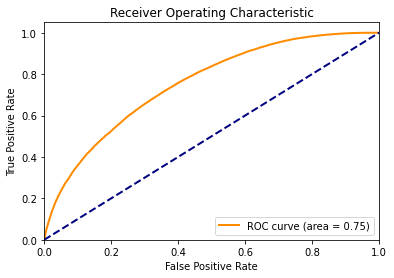

In [6]:
# Binarize the ratings in testset
testset_binarized = [1 if rating >= 4 else 0 for (_, _, rating) in testset]

# Predict ratings for the testset
preds = [pred.est for pred in predictions]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(testset_binarized, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Cross-validation

We implement cross-validation to get a more robust estimate of model's performance. 

In [7]:
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0352  1.0331  1.0311  1.0272  1.0309  1.0315  0.0027  
MAE (testset)     0.7616  0.7593  0.7580  0.7556  0.7570  0.7583  0.0020  
Fit time          8.13    8.74    8.65    8.54    8.64    8.54    0.22    
Test time         0.99    1.00    1.61    1.47    1.75    1.36    0.31    


{'test_rmse': array([1.03521107, 1.03310255, 1.03112916, 1.02716779, 1.03090962]),
 'test_mae': array([0.76156895, 0.75930879, 0.75800641, 0.75564947, 0.75701348]),
 'fit_time': (8.131620168685913,
  8.743112087249756,
  8.650327920913696,
  8.542724132537842,
  8.644946098327637),
 'test_time': (0.992419958114624,
  0.9996781349182129,
  1.608543872833252,
  1.4706718921661377,
  1.7524387836456299)}

### Using predictions to produce recommendations

In [8]:
# Predictions can now be made with the predict() method
# For example, predicting the rating of the item with id 'item_id' for the user with id 'user_id'
user_id = '6538326896'
item_id = 'P480354'
prediction = algo.predict(user_id, item_id)
print(prediction.est)

# Assume user_ids and item_ids are arrays or lists of user ids and item ids.
user_ids = ['7446977307', '1991973234', '42434587408']
item_ids = ['P467602', 'P481993', 'P481993']

# Assuming 'algo' is your trained model
predictions = [algo.predict(user_id, item_id) for user_id, item_id in zip(user_ids, item_ids)]

# Extract the estimated ratings
estimated_ratings = [pred.est for pred in predictions]

4.1216022215021475


In [9]:
user_id = '6538326896'  # replace with actual user id
item_ids = df['item_id'].unique()
preds = [algo.predict(user_id, item_id) for item_id in item_ids]
preds_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in preds], columns=['user_id', 'item_id', 'rating'])

n_recommendations = 5
top_n_recs = preds_df[preds_df['user_id'] == user_id].nlargest(n_recommendations, 'rating')
print(top_n_recs)

        user_id  item_id  rating
104  6538326896  P381030     5.0
145  6538326896  P377561     5.0
146  6538326896  P450917     5.0
247  6538326896  P405096     5.0
289  6538326896  P395615     5.0


### Provide top 10 recommendations to a user

In [10]:

def recommend_unreviewed_items(user_id, model, df, n_recommendations=10):
    # Get the item IDs that the user has already rated
    rated_item_ids = df[df['user_id'] == user_id]['item_id']

    # Get all item IDs
    all_item_ids = df['item_id'].unique()

    # Get the item IDs that the user hasn't rated yet
    unrated_item_ids = np.setdiff1d(all_item_ids, rated_item_ids)

    # Make predictions for the unrated items only
    preds = [model.predict(user_id, item_id) for item_id in unrated_item_ids]

    # Convert predictions to DataFrame
    preds_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in preds], columns=['user_id', 'item_id', 'rating'])

    # Get top N recommendations
    top_n_recs = preds_df.nlargest(n_recommendations, 'rating')

    return top_n_recs



In [11]:
# Example usage:
user_id = '6538326896'  # replace with actual user id
#print(recommend_unreviewed_items(user_id, algo, df))

print('For user ', user_id, ' we recommend items: ' , recommend_unreviewed_items(user_id, algo, df).item_id.tolist())

For user  6538326896  we recommend items:  ['P377561', 'P381030', 'P395615', 'P405096', 'P448852', 'P450917', 'P122762', 'P232915', 'P446930', 'P465803']


Through our exploration, we employed multiple machine learning methods, including SVD, NMF, KNN, and hybrid models like LightFM. SVD and LightFM (with both item and user features) showed promising results. Despite some challenges related to data sparsity and computational requirements, the models performed reasonably well.

### Exploring additional methods
Other common collaborative filtering algoriths include KNN, NMF and Biased SVD.

### Note on KNN
KNN algorithm is a simple and commonly used method for making recommendations, but it can struggle with large datasets due to its computational complexity.
KNN works by computing distances between items or users, which requires comparing each item (or user) to every other item (or user). As a result, the time and space complexity of the algorithm is quadratic in the number of items or users. This means that as the dataset grows, the time and memory required to run KNN increase rapidly.

For a dataset with 1,088,886 ratings of unique users and items, KNN was too slow and required a large amount of memory, so we consider using a more scalable algorithm.


### Model 2: NMF

In this code, we are using the default hyperparameters for the NMF algorithm, which are:

n_factors: The number of factors. Default is 15.
n_epochs: The number of iteration of the SGD procedure. Default is 50.
biased: Whether to use baselines (or biases). Default is True.

In [12]:
from surprise import NMF, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

algo2 = NMF()
algo2.fit(trainset)
predictions = algo2.test(testset)

# Then compute RMSE
print("RMSE: ", accuracy.rmse(predictions))

# compute MAE
print("MAE: ", accuracy.mae(predictions))


RMSE: 1.1521
RMSE:  1.1521099560794323
MAE:  0.8521
MAE:  0.8521020495090966


In [13]:
# Run 5-fold cross-validation and print results
cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1481  1.1576  1.1545  1.1564  1.1533  1.1540  0.0033  
MAE (testset)     0.8464  0.8604  0.8577  0.8579  0.8553  0.8556  0.0049  
Fit time          30.71   31.06   30.54   30.73   31.03   30.81   0.20    
Test time         0.96    2.25    1.90    0.91    2.12    1.63    0.58    


{'test_rmse': array([1.14810271, 1.15759585, 1.15454224, 1.15643616, 1.15334566]),
 'test_mae': array([0.84639629, 0.86044555, 0.85772659, 0.85788809, 0.85533644]),
 'fit_time': (30.707982063293457,
  31.057239055633545,
  30.54215908050537,
  30.734320878982544,
  31.032498836517334),
 'test_time': (0.9573092460632324,
  2.254385232925415,
  1.8976631164550781,
  0.9065380096435547,
  2.1175739765167236)}

Well it looks like the Mean RMSE is 1.10 and MAE is 0.79 while SVD had 0.91, 0.64 RMSE and MAE correspondingly. 
So SVD seems to do better.

### Model 3: Biased SVD

In [14]:
# Use the biased SVD algorithm
algo3 = SVD(biased = True) # default is True

In [15]:
# Run 5-fold cross-validation and print results
cross_validate(algo3, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0302  1.0290  1.0347  1.0314  1.0332  1.0317  0.0020  
MAE (testset)     0.7577  0.7550  0.7591  0.7579  0.7610  0.7581  0.0020  
Fit time          8.33    8.56    8.65    8.50    10.31   8.87    0.73    
Test time         1.00    0.94    0.96    1.02    1.05    0.99    0.04    


{'test_rmse': array([1.03018876, 1.02903014, 1.0347333 , 1.03138981, 1.03320733]),
 'test_mae': array([0.75771992, 0.75496766, 0.75912994, 0.75785965, 0.7609879 ]),
 'fit_time': (8.327718257904053,
  8.560170888900757,
  8.647213220596313,
  8.50456690788269,
  10.314241170883179),
 'test_time': (0.9993619918823242,
  0.9395031929016113,
  0.9560072422027588,
  1.0222668647766113,
  1.054103136062622)}

Well, it looks like Biased SVD performs better, but has longer fit time


In [16]:
predictions = algo3.test(testset)

# Then compute RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

# For precision and recall we need to define a threshold for positive vs. negative ratings
# Here we'll use 3.5 (on a 5-point scale), but this will depend on how your ratings are distributed
threshold = 3.5
true_positives = sum([1 for prediction in predictions if prediction.r_ui >= threshold and prediction.est >= threshold])
true_negatives = sum([1 for prediction in predictions if prediction.r_ui < threshold and prediction.est < threshold])
false_positives = sum([1 for prediction in predictions if prediction.r_ui < threshold and prediction.est >= threshold])
false_negatives = sum([1 for prediction in predictions if prediction.r_ui >= threshold and prediction.est < threshold])

# Compute precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")



RMSE: 0.6873
MAE:  0.4803
Precision: 0.92
Recall: 0.99
F1: 0.96


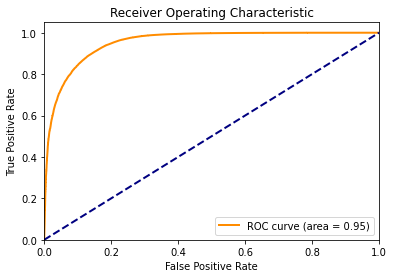

In [17]:
# Binarize the ratings in testset
testset_binarized = [1 if rating >= 4 else 0 for (_, _, rating) in testset]

# Predict ratings for the testset
preds = [pred.est for pred in predictions]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(testset_binarized, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Top 10 predictions for Biased SVD

In [18]:
# Example usage:
user_id = '6538326896'  # replace with actual user id
#print(recommend_unreviewed_items(user_id, algo, df))

print('For user ', user_id, ' we recommend items: ' , recommend_unreviewed_items(user_id, algo3, df).item_id.tolist())

For user  6538326896  we recommend items:  ['P203616', 'P411401', 'P504049', 'P473725', 'P470533', 'P122882', 'P188307', 'P419466', 'P423259', 'P472472']


In [19]:
product_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [21]:
item_ids = ['P421275', 'P122900', 'P423688', 'P442745', 'P428250', 'P481335', 'P454380', 'P443352', 'P470255', 'P420699']
subset_df = product_info[product_info['product_id'].isin(item_ids)]
subset_df.to_csv('../reports/figures/recommendation_result.csv', index=False)

In [22]:
# Create dataframe of true and predicted ratings
true_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]

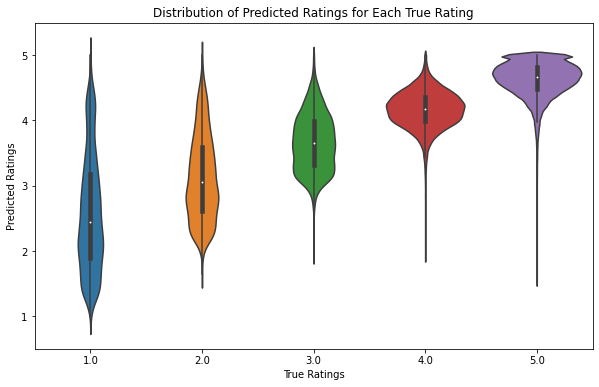

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dataframe from true and predicted ratings
df = pd.DataFrame(data={"True Ratings": true_ratings, "Predicted Ratings": predicted_ratings})

# Round predicted ratings to nearest integer to make groups for plotting
df['Predicted Ratings'] #= df['Predicted Ratings'].round()

# Generate violin plot
plt.figure(figsize=(10,6))
sns.violinplot(x="True Ratings", y="Predicted Ratings", data=df)
plt.title('Distribution of Predicted Ratings for Each True Rating')
plt.show()
